In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import pyplot
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score 
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, roc_auc_score

In [4]:
df = pd.read_csv("top10_data.csv", delimiter = ",")

In [5]:
#list to keep track of models and model_names
models = []
model_names = []

## Base Model

In [6]:
song_characteristics = ['Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness','Valence']
label = ['Top 10']

In [7]:
X = df[song_characteristics]
y = df[label]

X = X.values
y = y.values.reshape(-1)

#split the data into train and test sets
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#use SMOTE to oversample the minority class in the training set
smote = SMOTE(sampling_strategy=1, random_state=42)
X_train_base,y_train_base = smote.fit_resample(X_train_base,y_train_base)

#use SMOTE to oversample the minority class in the training set
smote = SMOTE(sampling_strategy=1, random_state=42)
X_test_base,y_test_base = smote.fit_resample(X_test_base,y_test_base)

In [8]:
#create a Logistic Regression model
lr_base = LogisticRegression(max_iter=1000, random_state = 42)

#fit the model to your training data
lr_base.fit(X_train_base, y_train_base)

#make predictions on the val data
y_pred = lr_base.predict(X_test_base)
y_probas = lr_base.predict_proba(X_test_base)[:, 1]

#evaluate the model
accuracy = accuracy_score(y_test_base, y_pred)
f1 = f1_score(y_test_base, y_pred)
roc_auc = roc_auc_score(y_test_base, y_probas)
report = classification_report(y_test_base, y_pred)
confusion = confusion_matrix(y_test_base, y_pred)
coefficients = lr_base.coef_[0]
models.append(lr_base)
model_names.append("Base LR")

#print out relevant model performance
print("Accuracy:", accuracy)
print("ROC_AUC_SCORE: " + str(roc_auc))
print("F1: " + str(f1))
print("---------------")
print("Feature Importance")
for i, val in enumerate(coefficients):
    print(song_characteristics[i] + ": " +  str(val))

print("---------------")
print("Classification Report:\n", report)

Accuracy: 0.551762114537445
ROC_AUC_SCORE: 0.5909466298373516
F1: 0.5590465872156012
---------------
Feature Importance
Danceability: 0.10242731399387536
Energy: -0.18402621441911343
Loudness: 0.09686322518806172
Speechiness: -0.11483667030331364
Acousticness: -0.02591361287760821
Instrumentalness: -0.07608790444731425
Valence: -0.1051511819981264
---------------
Classification Report:
               precision    recall  f1-score   support

       False       0.55      0.54      0.54      1362
        True       0.55      0.57      0.56      1362

    accuracy                           0.55      2724
   macro avg       0.55      0.55      0.55      2724
weighted avg       0.55      0.55      0.55      2724



# Prepare data for Model

In [9]:
#define features and label. Song characteristics is the numerical features
features = ['Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness',
            'Valence', 'Previous Popularity', "Number of Artists", 'Number Songs Previous', 'Previous Top Rank Avg']
song_characteristics = ['Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveliness',
                        'Valence']
label = ['Top 10']

In [10]:
X = df[features]
y = df[label]

#use SMOTE to oversample the minority class in the training set
X = X.values
y = y.values.reshape(-1)

#split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train_val, X_val, y_train_val, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=42, stratify=y_train)



#use SMOTE to oversample the minority class in the training set
smote = SMOTE(sampling_strategy=1, random_state=42)
X_train,y_train = smote.fit_resample(X_train,y_train)


#use SMOTE to oversample the minority class in the training set
smote = SMOTE(sampling_strategy=1, random_state=42)
X_test,y_test = smote.fit_resample(X_test,y_test)


#use SMOTE to oversample the minority class in the training set
smote = SMOTE(sampling_strategy=1, random_state=42)
X_train_val,y_train_val = smote.fit_resample(X_train_val,y_train_val)

#use SMOTE to oversample the minority class in the training set
smote = SMOTE(sampling_strategy=1, random_state=42)
X_val,y_val = smote.fit_resample(X_val,y_val)


In [11]:
from sklearn.metrics import roc_curve, roc_auc_score
#function to make the AUC_ROC graph for all models created on the validation set

roc = []

def makeGraph(y_val, X_val, models, model_names):
    plt.figure(figsize=(8, 8))

    for model, name in zip(models, model_names): 
        #if the base LR model, less features so create roc_auc accordingly
        if name == "Base LR":
            y_true = y_test_base
            y_probas = model.predict_proba(X_test_base)[:, 1]
            roc_auc = roc_auc_score(y_true, y_probas)
            print(f'{name} ROC AUC:', roc_auc)
            roc.append(roc_auc)

            fpr, tpr, _ = roc_curve(y_true, y_probas)

            plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
        #otherwise make the roc_auc based on all feature columns
        else:
            y_true = y_val
            y_probas = model.predict_proba(X_val)[:, 1]

            roc_auc = roc_auc_score(y_true, y_probas)
            print(f'{name} ROC AUC:', roc_auc)
            roc.append(roc_auc)

            fpr, tpr, _ = roc_curve(y_true, y_probas)

            plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

    #label axis
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right') 
    plt.show()

# Different models with no parameter adjustment

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report


#create a Gaussian Naive Bayes model
gnb = GaussianNB()

#fit the model to your training data
gnb.fit(X_train_val, y_train_val)

#make predictions on the val data
y_pred = gnb.predict(X_val)

#evaluate the model
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)
r = roc_auc_score(y_val, y_pred)
y_pred = gnb.predict(X_val)
f1 = f1_score(y_val, y_pred)


#print the evaluation metrics
print("Accuracy:", accuracy)
print("ROC_AUC_SCORE: " + str(r))
print("F1: " + str(f1))

print("Classification Report:\n", report)

Accuracy: 0.6359044995408631
ROC_AUC_SCORE: 0.6359044995408633
F1: 0.6571552096843926
Classification Report:
               precision    recall  f1-score   support

       False       0.66      0.57      0.61      1089
        True       0.62      0.70      0.66      1089

    accuracy                           0.64      2178
   macro avg       0.64      0.64      0.63      2178
weighted avg       0.64      0.64      0.63      2178



In [13]:
#create a Logistic Regression model
lr = LogisticRegression(max_iter=1000, random_state = 42)

#fit the model to your training data
lr.fit(X_train_val, y_train_val)

#make predictions on the val data
y_pred = lr.predict(X_val)
y_probas = lr.predict_proba(X_val)[:, 1]

#evaluate the model
accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_probas)
report = classification_report(y_val, y_pred)
confusion = confusion_matrix(y_val, y_pred)
coefficients = lr.coef_[0]

#print out model performance stats
print("Accuracy:", accuracy)
print("ROC_AUC_SCORE: " + str(roc_auc))
print("F1: " + str(f1))
print("---------------")
print("Feature Importance")
for i, val in enumerate(coefficients):
    print(features[i] + ": " +  str(val))

print("---------------")
print("Classification Report:\n", report)

#append model for making graph
models.append(lr)
model_names.append("Logistic Regression")

Accuracy: 0.6597796143250688
ROC_AUC_SCORE: 0.696864293658684
F1: 0.6322580645161289
---------------
Feature Importance
Danceability: 0.14469998271602147
Energy: -0.13150172082165518
Loudness: 0.09280242442594897
Speechiness: -0.1414247967925051
Acousticness: -0.028328868691935172
Instrumentalness: -0.17753076668679627
Valence: -0.009458877698514605
Previous Popularity: 1.0136159407088958
Number of Artists: 0.2722883146950549
Number Songs Previous: 0.004080380483565337
Previous Top Rank Avg: -0.0029903906414946624
---------------
Classification Report:
               precision    recall  f1-score   support

       False       0.64      0.73      0.68      1089
        True       0.69      0.58      0.63      1089

    accuracy                           0.66      2178
   macro avg       0.66      0.66      0.66      2178
weighted avg       0.66      0.66      0.66      2178



In [14]:
#Create an Extreme Gradient Boosting Classifier
xgbClass = XGBClassifier(random_state = 42)

#fit the model to your training data
xgbClass.fit(X_train_val, y_train_val)

#make predictions on the val data
y_pred = xgbClass.predict(X_val)

#evaluate the model
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)
r = roc_auc_score(y_val, y_pred)
y_pred = xgbClass.predict(X_val)
f1 = f1_score(y_val, y_pred)

#get feature importances
feature_importances = xgbClass.feature_importances_

#append models to list for making graph 
models.append(xgbClass)
model_names.append("XGB Classifier")

#print out relevant model performance metrics
print("Accuracy:", accuracy)
print("ROC_AUC_SCORE: " + str(r))
print("F1: " + str(f1))
print("-------------")
print("Feature Importance")
for i, feat_imp in enumerate(feature_importances):
    print(features[i] + ": " + str(feat_imp))

print("-------------")
print("Classification Report:\n", report)


Accuracy: 0.8328741965105602
ROC_AUC_SCORE: 0.8328741965105602
F1: 0.8161616161616161
-------------
Feature Importance
Danceability: 0.022433039
Energy: 0.025253959
Loudness: 0.03116868
Speechiness: 0.02689085
Acousticness: 0.024964958
Instrumentalness: 0.056781996
Valence: 0.022207275
Previous Popularity: 0.5713023
Number of Artists: 0.13457854
Number Songs Previous: 0.040527277
Previous Top Rank Avg: 0.043891173
-------------
Classification Report:
               precision    recall  f1-score   support

       False       0.78      0.92      0.85      1089
        True       0.91      0.74      0.82      1089

    accuracy                           0.83      2178
   macro avg       0.84      0.83      0.83      2178
weighted avg       0.84      0.83      0.83      2178



In [15]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, roc_auc_score


#create a SVM model
svc = SVC(kernel='linear', probability=True, random_state = 42)

#fit the model to your training data
svc.fit(X_train_val, y_train_val)

#make predictions on the val data
y_pred = svc.predict(X_val)
y_probas = svc.predict_proba(X_val)[:, 1]

#evaluate the model
accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_probas)
report = classification_report(y_val, y_pred)
confusion = confusion_matrix(y_val, y_pred)

#append model to list for graphing roc_auc
models.append(svc)
model_names.append("SVM")

#print out relevant model performance metrics
print("Accuracy:", accuracy)
print("ROC_AUC_SCORE: " + str(roc_auc))
print("F1: " + str(f1))
print("Classification Report:\n", report)

Accuracy: 0.6643709825528007
ROC_AUC_SCORE: 0.7104630072323537
F1: 0.6257040450588838
Classification Report:
               precision    recall  f1-score   support

       False       0.64      0.77      0.70      1089
        True       0.71      0.56      0.63      1089

    accuracy                           0.66      2178
   macro avg       0.67      0.66      0.66      2178
weighted avg       0.67      0.66      0.66      2178



In [16]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier

#create a KNearestNeighbors model
knn_clf = KNeighborsClassifier()

#fit the model to your training data
knn_clf.fit(X_train_val, y_train_val)

#make predictions on the val data
y_pred = knn_clf.predict(X_val)
y_probas = knn_clf.predict_proba(X_val)[:, 1]

#evaluate the model
accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_probas)
report = classification_report(y_val, y_pred)
confusion = confusion_matrix(y_val, y_pred)

#append model to list for graphing ROC_AUC 
models.append(knn_clf)
model_names.append("KNN")

print("Accuracy:", accuracy)
print("ROC_AUC_SCORE: " + str(roc_auc))
print("F1: " + str(f1))
print("Classification Report:\n", report)

Accuracy: 0.6230486685032139
ROC_AUC_SCORE: 0.6586319830747579
F1: 0.5892946473236619
Classification Report:
               precision    recall  f1-score   support

       False       0.61      0.71      0.65      1089
        True       0.65      0.54      0.59      1089

    accuracy                           0.62      2178
   macro avg       0.63      0.62      0.62      2178
weighted avg       0.63      0.62      0.62      2178



In [17]:
#create a Random Forest classifier
rf = RandomForestClassifier(random_state=42)

#fit the model to the training data
rf.fit(X_train_val, y_train_val)

#make predictions on the val data
y_pred = rf.predict(X_val)
y_probas = rf.predict_proba(X_val)[:, 1]

#evaluate model
accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_probas)
report = classification_report(y_val, y_pred)
confusion = confusion_matrix(y_val, y_pred)

#get feature importances
feature_importances = rf.feature_importances_

#print out relevant model performance stats
print("Accuracy:", accuracy)
print("ROC_AUC_SCORE: " + str(roc_auc))
print("F1: " + str(f1))
print("-------------")
print("Feature Importance")
for i, feat_imp in enumerate(feature_importances):
    print(features[i] + ": " + str(feat_imp))

print("-------------")
print("Classification Report:\n", report)

#append model to list for graphing ROC_AUC
models.append(rf)
model_names.append("RF")

Accuracy: 0.7736455463728191
ROC_AUC_SCORE: 0.86336653116017
F1: 0.7301587301587302
-------------
Feature Importance
Danceability: 0.09163571144937932
Energy: 0.09235144656174044
Loudness: 0.10387577939872415
Speechiness: 0.09476155058091369
Acousticness: 0.09798295289680714
Instrumentalness: 0.03305609253143222
Valence: 0.0844756428417619
Previous Popularity: 0.10569739227723357
Number of Artists: 0.07055368619418426
Number Songs Previous: 0.08813561025770801
Previous Top Rank Avg: 0.13747413501011532
-------------
Classification Report:
               precision    recall  f1-score   support

       False       0.71      0.93      0.81      1089
        True       0.90      0.61      0.73      1089

    accuracy                           0.77      2178
   macro avg       0.81      0.77      0.77      2178
weighted avg       0.81      0.77      0.77      2178



In [18]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, classification_report


#create a GradientBoostingClassifier model
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

#fit the model to your training data
gb.fit(X_train_val, y_train_val)

#make predictions on the val data
y_pred = gb.predict(X_val)

#evaluate the model
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)
y_pred = gb.predict(X_val)
f1 = f1_score(y_val, y_pred)


#print the evaluation metrics
print("Accuracy:", accuracy)
print("ROC_AUC_SCORE: " + str(r))
print("F1: " + str(f1))
print("Classification Report:\n", report)

Accuracy: 0.820018365472911
ROC_AUC_SCORE: 0.8328741965105602
F1: 0.8156161806208843
Classification Report:
               precision    recall  f1-score   support

       False       0.81      0.84      0.82      1089
        True       0.84      0.80      0.82      1089

    accuracy                           0.82      2178
   macro avg       0.82      0.82      0.82      2178
weighted avg       0.82      0.82      0.82      2178



Base LR ROC AUC: 0.5909466298373516
Logistic Regression ROC AUC: 0.696864293658684
XGB Classifier ROC AUC: 0.9099391949379427
SVM ROC AUC: 0.7104630072323537
KNN ROC AUC: 0.6586319830747579
RF ROC AUC: 0.86336653116017


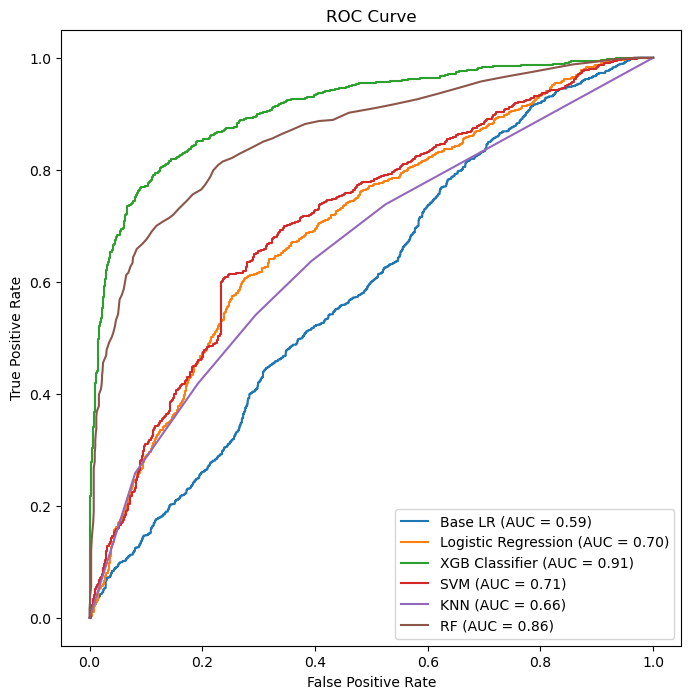

In [19]:
#use makeGraph function to display auc_roc scores and ROC curve
makeGraph(y_val, X_val, models, model_names)

## Param Tuning XGB Classifier and testing on Test Set

In [20]:
#define the hyperparameter values to search over
n_estimators_values = [100, 200, 300]
learning_rate = [0.01, 0.1, 0.2]
max_depth_values = [3, 5, 10]
subsample = [0.8, 0.9, 1.0]
colsample_bytree = [0.8, 0.9, 1.0]

#initialize variables for best hyperparameters and best accuracy
best_n_estimators = None
best_max_depth = None
best_f1 = 0
best_sub = 0
best_colsample = 0
best_learning = 0

#iterate over each combination of hyperparameters
for n_estimators in n_estimators_values:
    for max_depth in max_depth_values:
        for sub in subsample:
            for colsample in colsample_bytree:
                for learning in learning_rate:
                #create a Random Forest classifier model with current hyperparameters
                    xgbClass = XGBClassifier( 
                        subsample=sub,
                        colsample_bytree=colsample,
                        n_estimators = n_estimators,
                        learning_rate = learning,
                        objective='binary:logistic',  
                        eval_metric='logloss',
                        random_state = 42
                    )

                    #fit the model to your training data
                    xgbClass.fit(X_train_val, y_train_val)

                    #make predictions on the val data
                    y_pred = xgbClass.predict(X_val)
                    f1 = f1_score(y_val, y_pred)
                    #check if the current accuracy is better than the previous best accuracy
                    if f1 > best_f1:
                        #update the best hyperparameters and best accuracy
                        best_n_estimators = n_estimators
                        best_max_depth = max_depth
                        best_accuracy = accuracy
                        best_learning = learning
                        best_colsample = colsample
                        best_sub = sub
                        best_f1 = f1

#print the best hyperparameters and best F1 score
print("Best Hyperparameters:")
print("n_estimators:", best_n_estimators)
print("max_depth:", best_max_depth)
print("Best F1:", best_f1)
print("Best Learning:", best_learning)
print("Best Colsample:", best_colsample)
print("Best Sub:", best_sub)


Best Hyperparameters:
n_estimators: 200
max_depth: 3
Best F1: 0.8296075509190263
Best Learning: 0.1
Best Colsample: 0.9
Best Sub: 1.0


In [21]:
#xbg with parameter tuning
xgbClass_tuned = XGBClassifier( 
                        subsample=best_sub,
                        colsample_bytree=best_colsample,
                        n_estimators = best_n_estimators,
                        learning_rate = best_learning,
                        max_depth = best_max_depth,
                        objective='binary:logistic',  
                        eval_metric='logloss',
                        random_state = 42
                    )

                    #fit the model to your training data
xgbClass_tuned.fit(X_train_val, y_train_val)

#make predictions on the val data
y_pred = xgbClass_tuned.predict(X_val)
f1 = f1_score(y_val, y_pred)
y_true = y_val
y_probas = xgbClass_tuned.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_true, y_probas)
accuracy = accuracy_score(y_val, y_pred)

#print out model performance
print("Accuracy: " + str(accuracy))
print("ROC_AUC: " + str(roc_auc))
print("F1: " + str(f1))

Accuracy: 0.8191000918273645
ROC_AUC: 0.9055160503945878
F1: 0.8118433619866284


In [22]:
#run on test for best parameters
xgbClass_tuned = XGBClassifier( 
                        subsample=(best_sub),
                        colsample_bytree=best_colsample,
                        n_estimators = best_n_estimators,
                        learning_rate = best_learning,
                        max_depth = best_max_depth,
                        objective='binary:logistic',  
                        eval_metric='logloss',
                        random_state = 42
                        )

                    #fit the model to your entire training data
xgbClass_tuned.fit(X_train, y_train)

#make predictions on the test data
y_pred = xgbClass_tuned.predict(X_test)
f1 = f1_score(y_test, y_pred)
y_true = y_test
y_probas = xgbClass_tuned.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_true, y_probas)
accuracy = accuracy_score(y_test, y_pred)
feature_importances = xgbClass_tuned.feature_importances_
feature_importances

#print out model performance
print("Accuracy: " + str(accuracy))
print("ROC_AUC: " + str(roc_auc))
print("F1: " + str(f1))
print("-------------")
print("Feature Importance")
for i, feat_imp in enumerate(feature_importances):
    print(features[i] + ": " + str(feat_imp))

print("-------------")

Accuracy: 0.7863436123348018
ROC_AUC: 0.8759590069022621
F1: 0.7776928953399542
-------------
Feature Importance
Danceability: 0.032140166
Energy: 0.03173845
Loudness: 0.046205472
Speechiness: 0.042656604
Acousticness: 0.03271086
Instrumentalness: 0.06670809
Valence: 0.021607418
Previous Popularity: 0.4473065
Number of Artists: 0.12503499
Number Songs Previous: 0.056239285
Previous Top Rank Avg: 0.09765223
-------------


## Param Tuning Random Forest and testing on Test Set

In [23]:
#define the hyperparameter values to search over
n_estimators_values = [100, 200, 300]
max_depth_values = [1, 2, 5, 10]
min_samples_split_values = [2, 4, 6]
min_samples_leaf_values = [1, 2, 3]

#initialize variables for best hyperparameters and best accuracy
best_n_estimators = None
best_max_depth = None
best_min_samples_split = None
best_min_samples_leaf = None
best_accuracy = 0
best_f1 = 0
best_roc_auc = 0

#iterate over each combination of hyperparameters
for n_estimators in n_estimators_values:
    for max_depth in max_depth_values:
        for min_samples_split in min_samples_split_values:
            for min_samples_leaf in min_samples_leaf_values:
                #create a Random Forest classifier model with current hyperparameters
                model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                               min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                               random_state=42)
                
                #fit the model on the training data
                model.fit(X_train_val, y_train_val)
                
                #evaluate the model on the validation data
                accuracy = model.score(X_val, y_val)

                f1 = f1_score(y_val, model.predict(X_val))
                roc_auc = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])
                
                #if found better f1-score, save current params
                if f1>best_f1:
                    best_f1 = f1
                    best_n_estimators = n_estimators
                    best_max_depth = max_depth
                    best_min_samples_split = min_samples_split
                    best_min_samples_leaf = min_samples_leaf
                    

#print the best hyperparameters and best F1
print("Best Hyperparameters:")
print("n_estimators:", best_n_estimators)
print("max_depth:", best_max_depth)
print("min_samples_split:", best_min_samples_split)
print("min_samples_leaf:", best_min_samples_leaf)
print("Best F1:", best_f1)

Best Hyperparameters:
n_estimators: 200
max_depth: 10
min_samples_split: 2
min_samples_leaf: 3
Best F1: 0.7932367149758455


In [24]:
#fit model on valdidation for best parameters
#model tuned and performed on test set
rf_model_tuned = RandomForestClassifier(n_estimators=best_n_estimators, max_depth=best_max_depth,
                               min_samples_split=best_min_samples_split, min_samples_leaf=best_min_samples_leaf,
                               random_state=42)
#fit model
rf_model_tuned.fit(X_train_val, y_train_val)

#gather predictions and f1 score/ROC_AUC score
y_pred = rf_model_tuned.predict(X_val)
f1 = f1_score(y_val, y_pred)
y_true = y_val
y_probas = rf_model_tuned.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_true, y_probas)
accuracy = accuracy_score(y_val, y_pred)

#print out model performance
print("Accuracy: " + str(accuracy))
print("ROC_AUC: " + str(roc_auc))
print("F1: " + str(f1))

Accuracy: 0.8034894398530762
ROC_AUC: 0.8881114340668561
F1: 0.7932367149758455


In [25]:
#model tuned and performed on test set
rf_model_tuned = RandomForestClassifier(n_estimators=best_n_estimators, max_depth=best_max_depth,
                               min_samples_split=best_min_samples_split, min_samples_leaf=best_min_samples_leaf,
                               random_state=42)
#fit model
rf_model_tuned.fit(X_train, y_train)

#gather predictions and f1 score/ROC_AUC score
y_pred = rf_model_tuned.predict(X_test)
f1 = f1_score(y_test, y_pred)
y_true = y_test
y_probas = rf_model_tuned.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_true, y_probas)
accuracy = accuracy_score(y_test, y_pred)

#get feature importances
feature_importances = rf_model_tuned.feature_importances_

#print out model performance
print("Accuracy: " + str(accuracy))
print("ROC_AUC: " + str(roc_auc))
print("F1: " + str(f1))
print("-------------")
print("Feature Importance")
for i, feat_imp in enumerate(feature_importances):
    print(features[i] + ": " + str(feat_imp))
print("-------------")

Accuracy: 0.7580763582966226
ROC_AUC: 0.8427996856139262
F1: 0.7424775302852675
-------------
Feature Importance
Danceability: 0.05432338866411442
Energy: 0.06224967481030718
Loudness: 0.07772027256663237
Speechiness: 0.07330088161110362
Acousticness: 0.06514341603416401
Instrumentalness: 0.02388179149179385
Valence: 0.0403936141401221
Previous Popularity: 0.2098197062133015
Number of Artists: 0.09416985718046109
Number Songs Previous: 0.10479657443634113
Previous Top Rank Avg: 0.19420082285165877
-------------
